In [1222]:
from region_detection import *
from commonfunctions import *

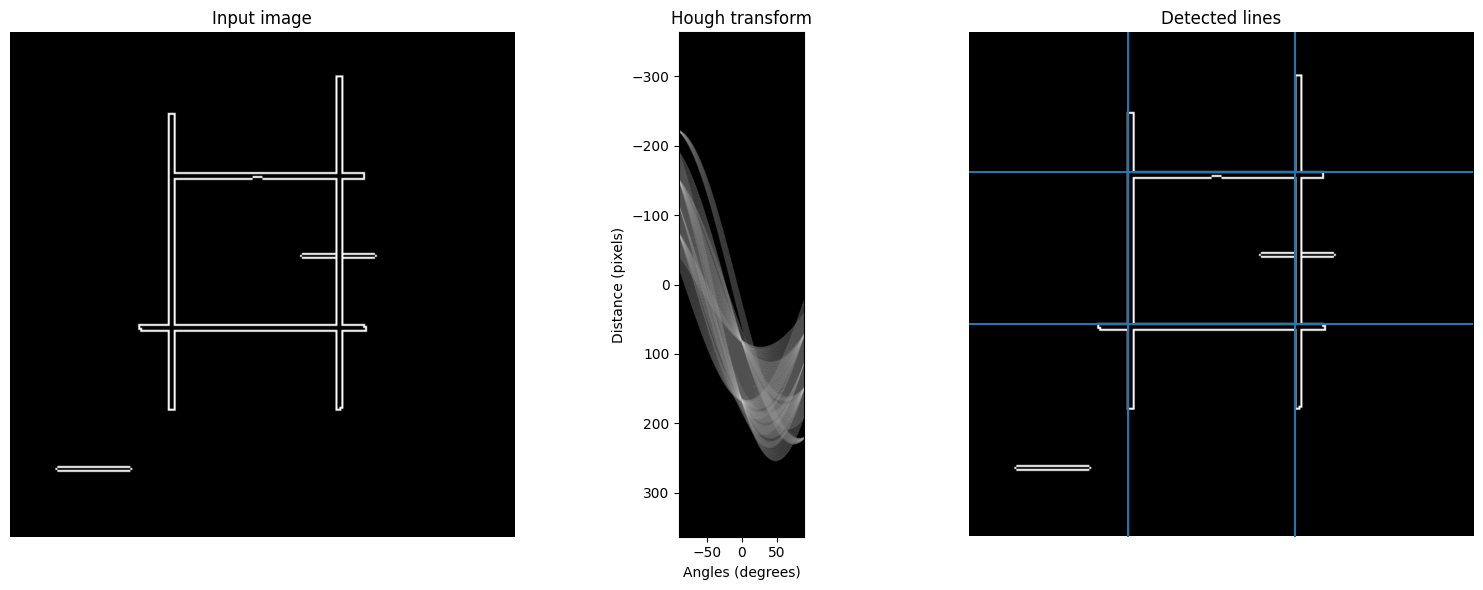

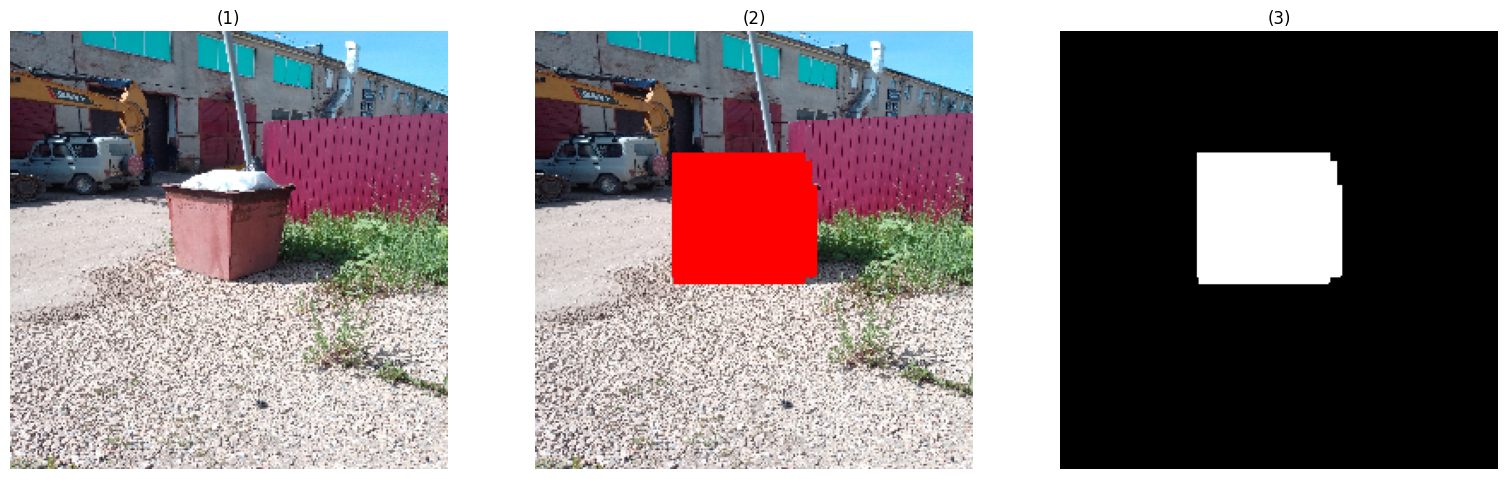

In [1223]:
cow_select=io.imread('images-to-be-tested/test1.png')
cow_orig=io.imread('images-to-be-tested/16.jpg')

target_img_size = (256, 256)

cow_sel_resize = cv2.resize(cow_select, target_img_size)
cow_sel_conversion = cow_sel_resize[:,:,:3]
cow_resized_orig = cv2.resize(cow_orig[:,:,:3], target_img_size)


# # Create an instance of the RegionDetection overlap=32
region_detector_1 = RegionDetection(cow_resized_orig, cow_sel_conversion)
region_mask, binary_mask_test=region_detector_1.get_mask_by_region_detection()

In [1224]:
# io.imshow(binary_mask_test)

In [1225]:
def MSD(target_patch, exemplar_patch, M_bar):
    # if not np.isin(1,M_bar):
    #     return float('inf')
    if np.sum(M_bar)==0:
        return float('inf')
    else:
     msd=np.sum((M_bar*target_patch - M_bar*exemplar_patch)**2)/np.sum(M_bar)
     return msd
    # return msd

    # msd=np.sum((M_bar*target_patch - M_bar*exemplar_patch)**2)

    

def SMD (target_patch, exemplar_patch, binary_mask, M_bar):
    # if not np.isin(1,M_bar):
    #     return float('inf')
    if np.sum(M_bar)==0:
        return float('inf')
    if np.sum(binary_mask)==0:
        return float('inf')
    target_existing_avg= np.sum(M_bar * target_patch)/np.sum(M_bar)
    exemplar_fill_avg = np.sum(binary_mask* exemplar_patch)/np.sum(binary_mask)
    smd= (target_existing_avg-exemplar_fill_avg)**2
    return smd 

    # target_existing_avg= np.sum(M_bar * target_patch)
    # exemplar_fill_avg = np.sum(binary_mask* exemplar_patch)
    # smd= (target_existing_avg-exemplar_fill_avg)**2
    # return smd 

def findBestsubPatch(target_patch, exemplar_patches, binary_mask, M_bar):
    best_patch = exemplar_patches[int(len(exemplar_patches)/2)]
    min_combined_error = float('inf')

    for other_patch in exemplar_patches:
        current_error = MSD((rgb2gray(target_patch)*255).astype('uint8'), (rgb2gray(other_patch)*255).astype('uint8'), M_bar) + SMD((rgb2gray(target_patch)*255).astype('uint8'), (rgb2gray(other_patch)*255).astype('uint8'), binary_mask, M_bar)
        if current_error < min_combined_error:
            best_patch = other_patch
            min_combined_error = current_error

    return best_patch


def findBestFullPatch(target_patches, exemplar_patches,binary_mask_patches, M_bar_patches):
    cp_target_patches = np.copy(target_patches)
    for i,target_patch in enumerate(target_patches):
        best_sub_patch=findBestsubPatch(target_patch,exemplar_patches,binary_mask_patches[i],M_bar_patches[i])
        
        cp_target_patches[i][binary_mask_patches[i] == 1] = best_sub_patch[binary_mask_patches[i] == 1]
    return cp_target_patches


In [1226]:
def main(img, binary_mask, overlap=64, patch_size=64):
    white_pixels = np.sum(binary_mask == 1)
    black_pixels = np.sum(binary_mask == 0)

# Calculate the ratio
    ratio = white_pixels / (white_pixels + black_pixels)
    if ratio < 0.15:
        overlap = 64
        patch_size =64
    elif ratio >0.3:
        overlap = 80
        patch_size =80
    else:
        overlap = 32
        patch_size =32

    img_in_patches = [img[i:i+patch_size, j:j+patch_size] for i in range(0, img.shape[0]-patch_size+1, overlap) for j in range(0, img.shape[1]-patch_size+1, overlap)]
    full_binary_mask_patches = [binary_mask[i:i+patch_size, j:j+patch_size] for i in range(0, img.shape[0]-patch_size+1, overlap) for j in range(0, img.shape[1]-patch_size+1, overlap)]

    target_indices = []
    exemplar_indices = []
    binary_mask_patches = []
    target_patches = []
    exemplar_patches = []
    target_patch_counter = 0
    patches_per_row = (img.shape[0] - patch_size) // overlap + 1
    patches_per_col = (img.shape[1] - patch_size) // overlap + 1

    for i, binary_mask_patch in enumerate(full_binary_mask_patches):
        start_row = (i // patches_per_row) * overlap
        start_col = (i % patches_per_row) * overlap
        if np.isin(1, binary_mask_patch):
            target_indices.append((target_patch_counter, start_row, start_col))
            binary_mask_patches.append(full_binary_mask_patches[i])
            target_patches.append(img_in_patches[i])
            target_patch_counter += 1
        else:
            exemplar_indices.append((i, start_row, start_col))
            exemplar_patches.append(img_in_patches[i])

    M_bar_patches = [1 - binary_mask_patches[i] for i in range(len(binary_mask_patches))]

    new_img = np.copy(img)

    while target_patch_counter > 0:
        for target_index, start_row, start_col in target_indices:
            best_sub_patch = findBestsubPatch(target_patches[target_index], exemplar_patches, binary_mask_patches[target_index], M_bar_patches[target_index])
            new_img[start_row: start_row + patch_size, start_col:start_col + patch_size] = best_sub_patch
            binary_mask_patches[target_index].fill(0)  # Fill the binary mask region with black
            target_patch_counter -= 1

        # Update target patches and M_bar_patches based on the new binary_mask_patches
        target_indices = []
        target_patches = []
        M_bar_patches = []

        for i, binary_mask_patch in enumerate(binary_mask_patches):
            start_row = (i // patches_per_row) * overlap
            start_col = (i % patches_per_row) * overlap
            if np.isin(1, binary_mask_patch):
                target_indices.append((target_patch_counter, start_row, start_col))
                target_patches.append(new_img[start_row: start_row + patch_size, start_col:start_col + patch_size])
                M_bar_patches.append(1 - binary_mask_patch)
                target_patch_counter += 1

    return new_img


In [1227]:
binary_mask_test=binary_mask_test[:,:,0]
grayLevelImg = cow_resized_orig#(rgb2gray(cow_resized_orig)*255).astype('uint8')


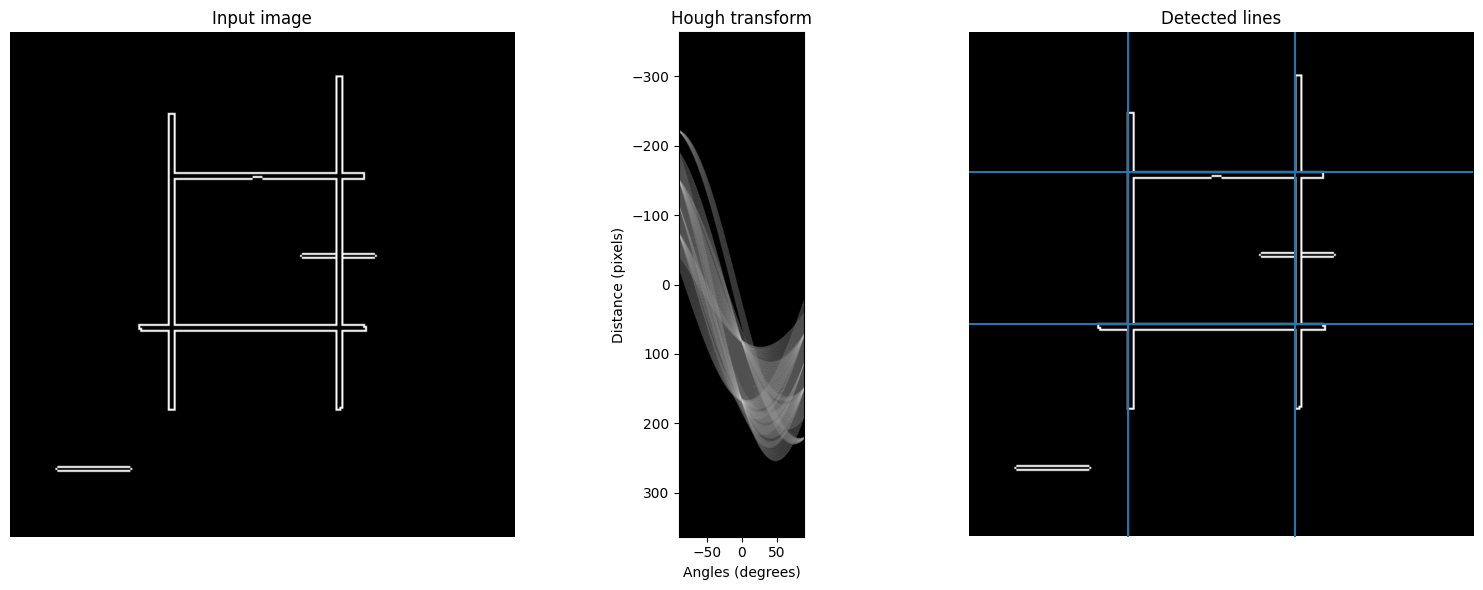

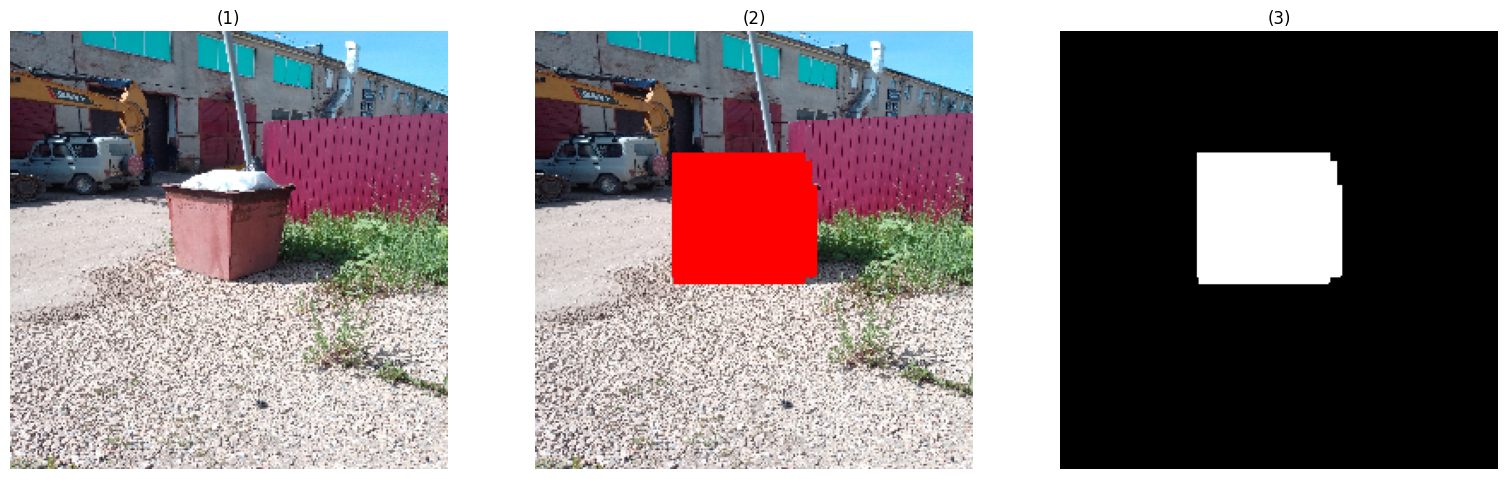

Ratio of white to black pixels: 0.098175048828125


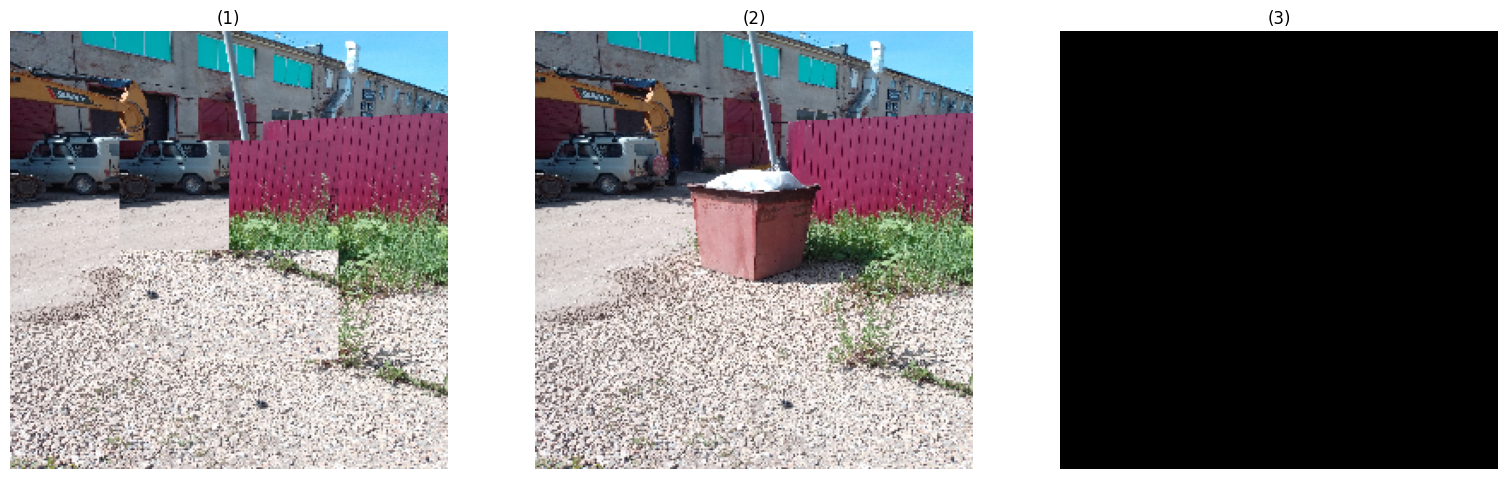

In [1228]:
cow_select=io.imread('images-to-be-tested/test1.png')
cow_orig=io.imread('images-to-be-tested/16.jpg')

target_img_size = (256, 256)

cow_sel_resize = cv2.resize(cow_select, target_img_size)
cow_sel_conversion = cow_sel_resize[:,:,:3]
cow_resized_orig = cv2.resize(cow_orig[:,:,:3], target_img_size)


# # Create an instance of the RegionDetection class
region_detector_1 = RegionDetection(cow_resized_orig, cow_sel_conversion)
region_mask, binary_mask_test=region_detector_1.get_mask_by_region_detection()

binary_mask_test=binary_mask_test[:,:,0]
grayLevelImg = cow_resized_orig#(rgb2gray(cow_resized_orig)*255).astype('uint8')
white_pixels = np.sum(binary_mask_test == 1)
black_pixels = np.sum(binary_mask_test == 0)

# Calculate the ratio
ratio = white_pixels / (white_pixels + black_pixels)
print(f"Ratio of white to black pixels: {ratio}")

newImg= main(grayLevelImg,binary_mask_test)
show_images([newImg,grayLevelImg,   binary_mask_test])


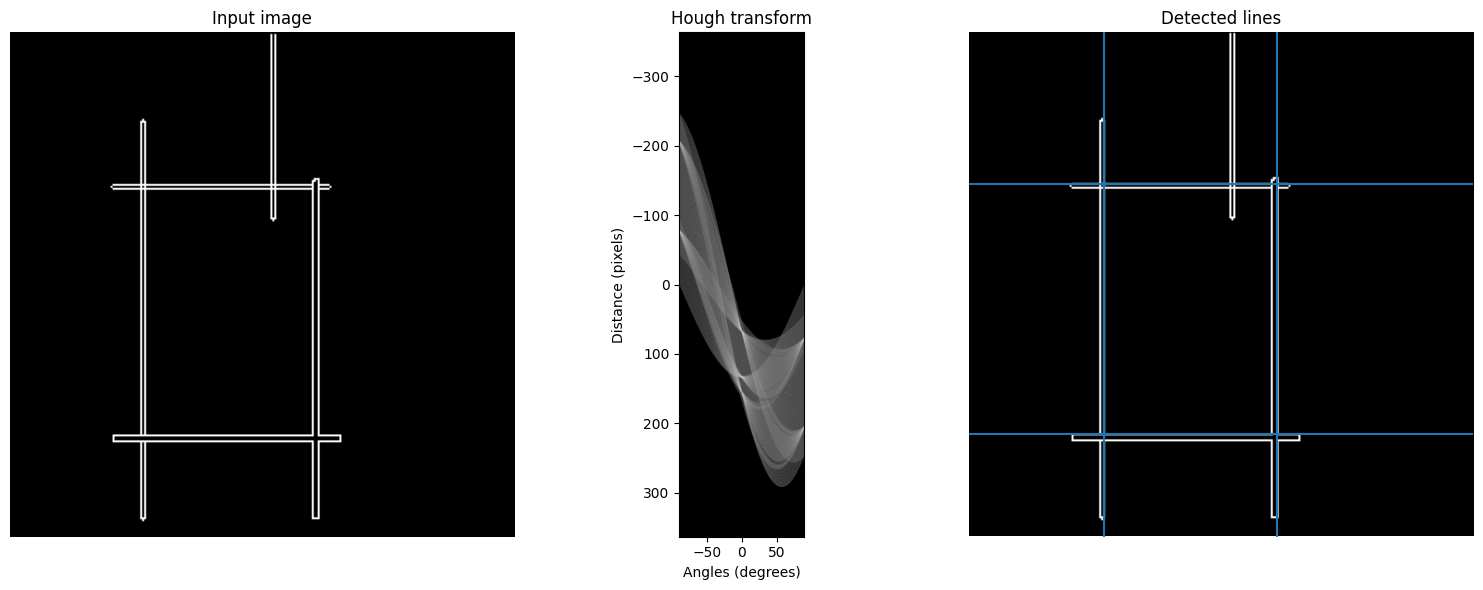

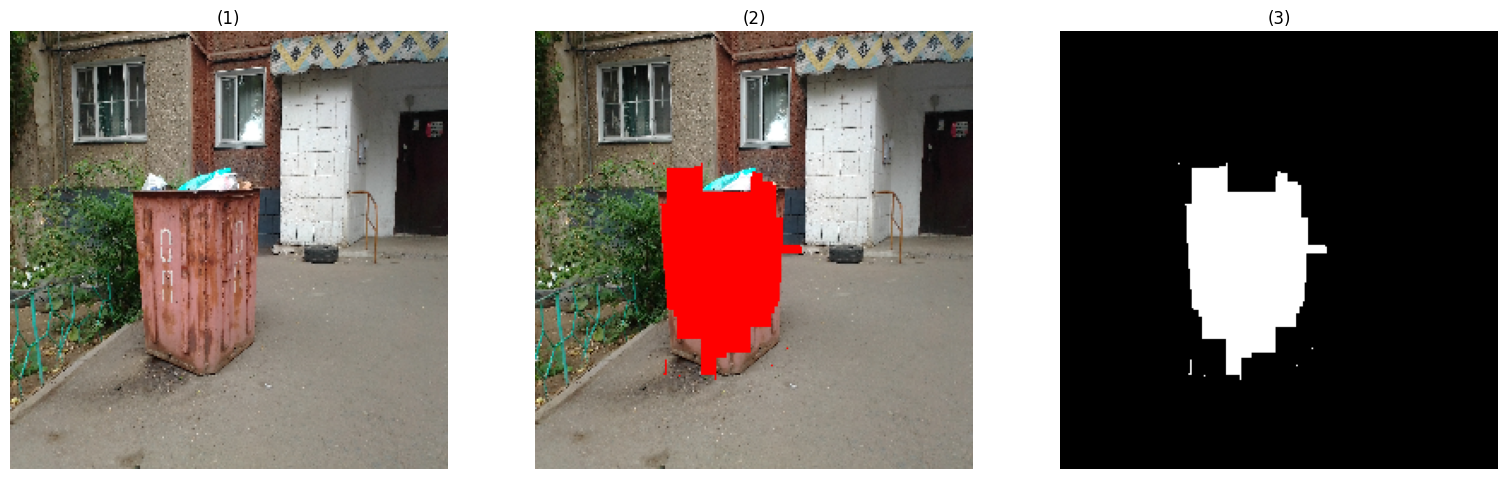

Ratio of white to black pixels: 0.0977783203125


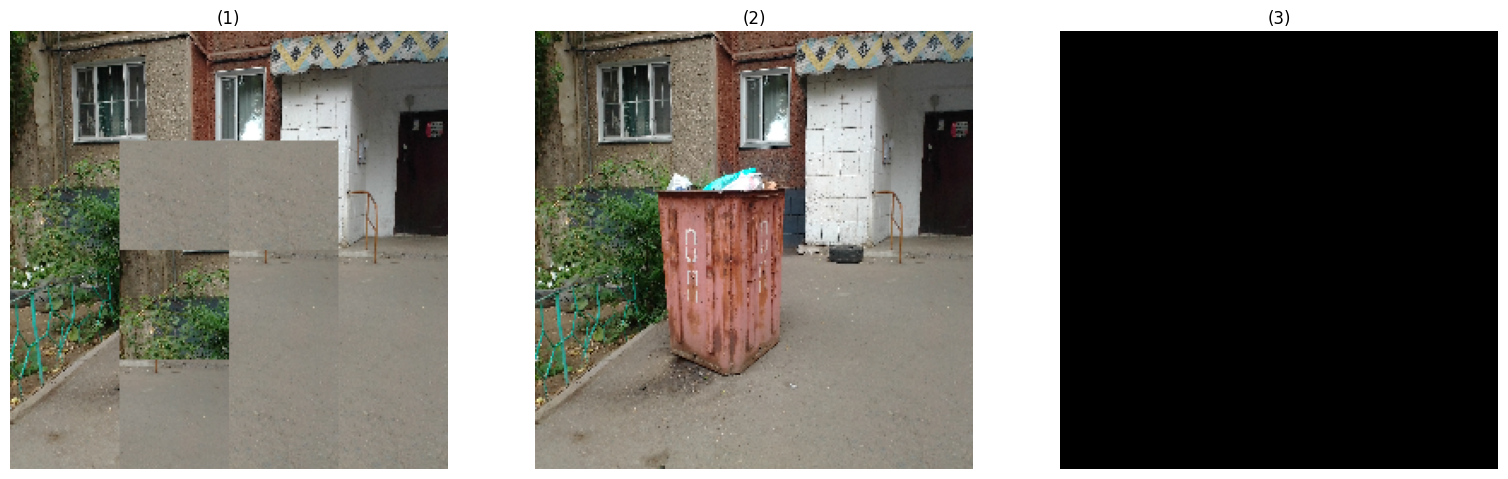

In [1229]:
cow_select=io.imread('images-to-be-tested/garbage_with_selection.png')
cow_orig=io.imread('images-to-be-tested/garbage.jpg')

target_img_size = (256, 256)

cow_sel_resize = cv2.resize(cow_select, target_img_size)
cow_sel_conversion = cow_sel_resize[:,:,:3]
cow_resized_orig = cv2.resize(cow_orig[:,:,:3], target_img_size)


# # Create an instance of the RegionDetection overlap=32
region_detector_1 = RegionDetection(cow_resized_orig, cow_sel_conversion)
region_mask, binary_mask_test=region_detector_1.get_mask_by_region_detection()

binary_mask_test=binary_mask_test[:,:,0]
grayLevelImg = cow_resized_orig#(rgb2gray(cow_resized_orig)*255).astype('uint8')
# Calculate the ratio
white_pixels = np.sum(binary_mask_test == 1)
black_pixels = np.sum(binary_mask_test == 0)
ratio = white_pixels / (white_pixels + black_pixels)
print(f"Ratio of white to black pixels: {ratio}")
newImg= main(grayLevelImg,binary_mask_test,64,64)
show_images([newImg,grayLevelImg,   binary_mask_test])





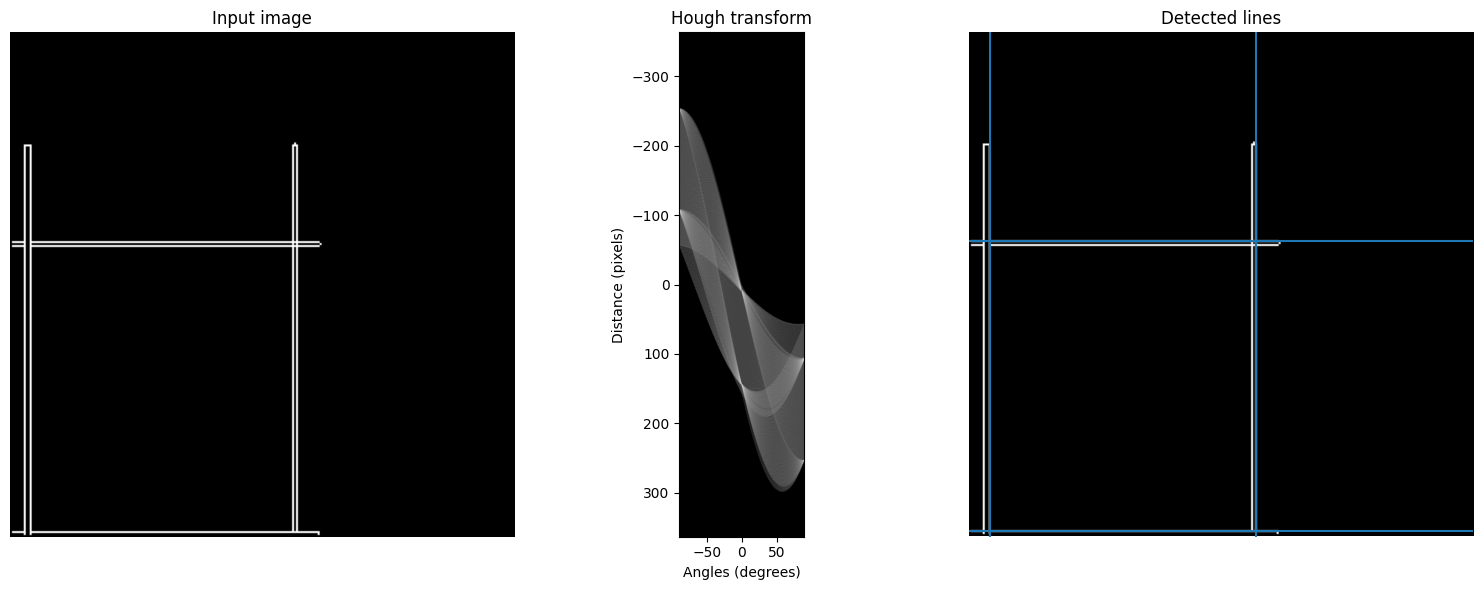

KeyboardInterrupt: 

In [1230]:
cow_select=io.imread('images-to-be-tested/garb2_with_sel.png')
cow_orig=io.imread('images-to-be-tested/garb2.jpg')

target_img_size = (256, 256)

cow_sel_resize = cv2.resize(cow_select, target_img_size)
cow_sel_conversion = cow_sel_resize[:,:,:3]
cow_resized_orig = cv2.resize(cow_orig[:,:,:3], target_img_size)


# # Create an instance of the RegionDetection overlap=32
region_detector_1 = RegionDetection(cow_resized_orig, cow_sel_conversion)
region_mask, binary_mask_test=region_detector_1.get_mask_by_region_detection()

binary_mask_test=binary_mask_test[:,:,0]
grayLevelImg = cow_resized_orig#(rgb2gray(cow_resized_orig)*255).astype('uint8')
white_pixels = np.sum(binary_mask_test == 1)
black_pixels = np.sum(binary_mask_test == 0)

# Calculate the ratio
ratio = white_pixels / (white_pixels + black_pixels)
print(f"Ratio of white to black pixels: {ratio}")

newImg= main(grayLevelImg,binary_mask_test,80,80)
show_images([newImg,grayLevelImg,   binary_mask_test])



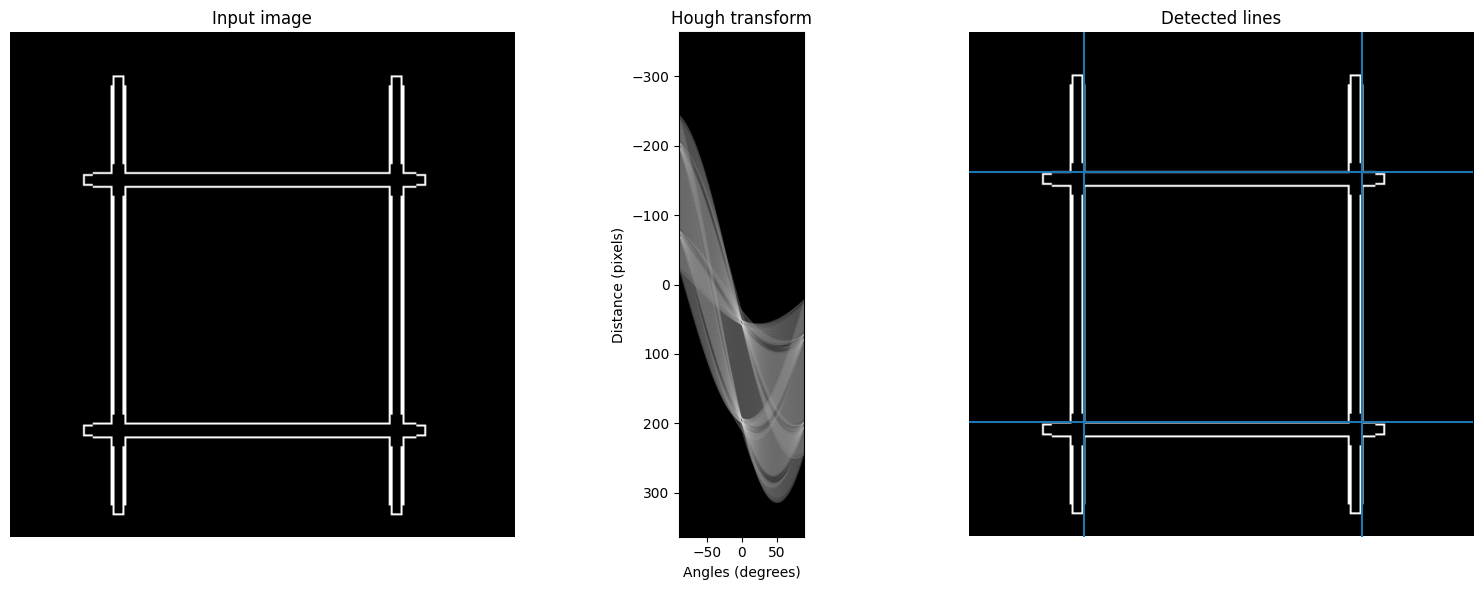

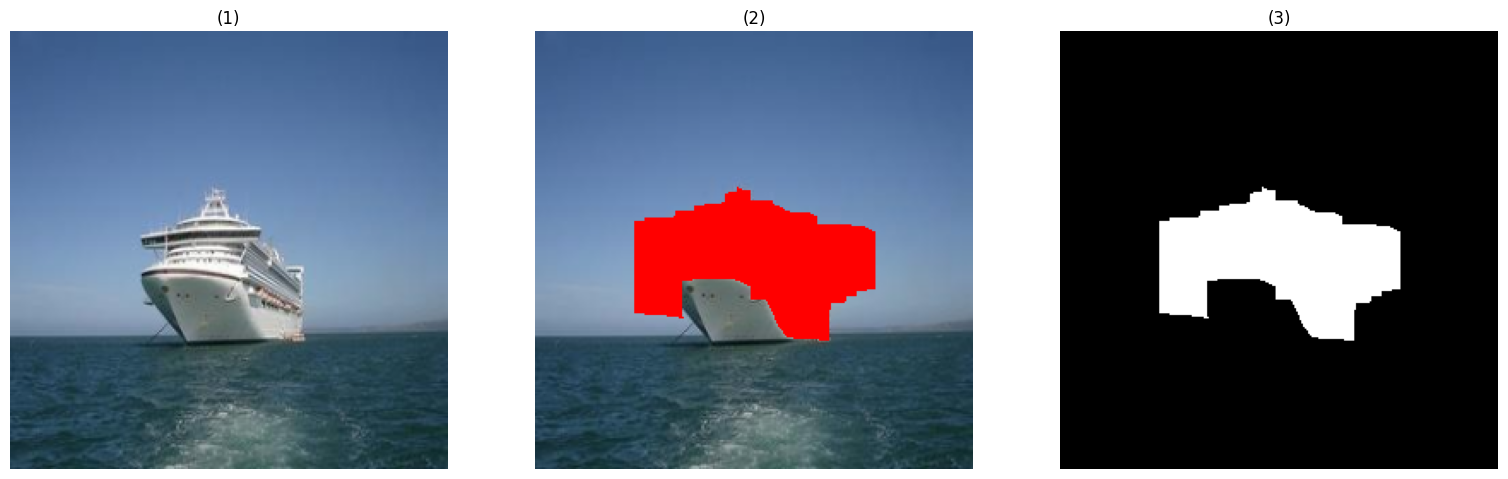

Ratio of white to black pixels: 0.1177978515625


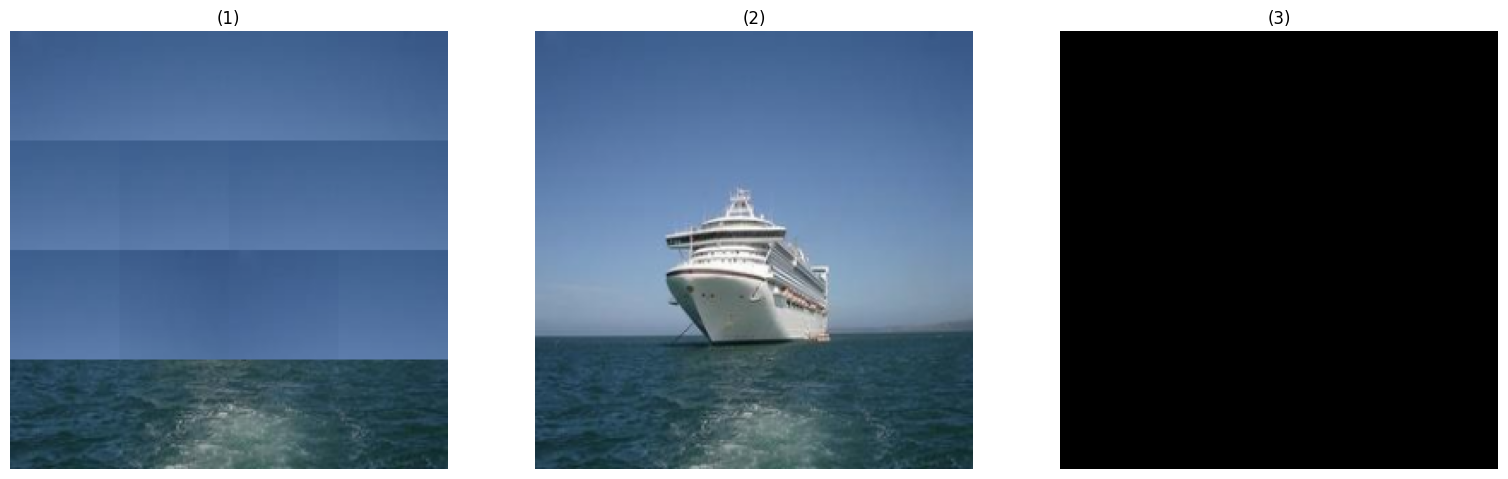

In [ ]:
cow_select=io.imread('images-to-be-tested/test3.png')
cow_orig=io.imread('images-to-be-tested/ship.jpg')

target_img_size = (256, 256)

cow_sel_resize = cv2.resize(cow_select, target_img_size)
cow_sel_conversion = cow_sel_resize[:,:,:3]
cow_resized_orig = cv2.resize(cow_orig[:,:,:3], target_img_size)


# # Create an instance of the RegionDetection overlap=32
region_detector_1 = RegionDetection(cow_resized_orig, cow_sel_conversion)
region_mask, binary_mask_test=region_detector_1.get_mask_by_region_detection()

binary_mask_test=binary_mask_test[:,:,0]
grayLevelImg = cow_resized_orig#(rgb2gray(cow_resized_orig)*255).astype('uint8')
white_pixels = np.sum(binary_mask_test == 1)
black_pixels = np.sum(binary_mask_test == 0)

# Calculate the ratio
ratio = white_pixels / (white_pixels + black_pixels)
print(f"Ratio of white to black pixels: {ratio}")
newImg= main(grayLevelImg,binary_mask_test)
show_images([newImg,grayLevelImg,   binary_mask_test])



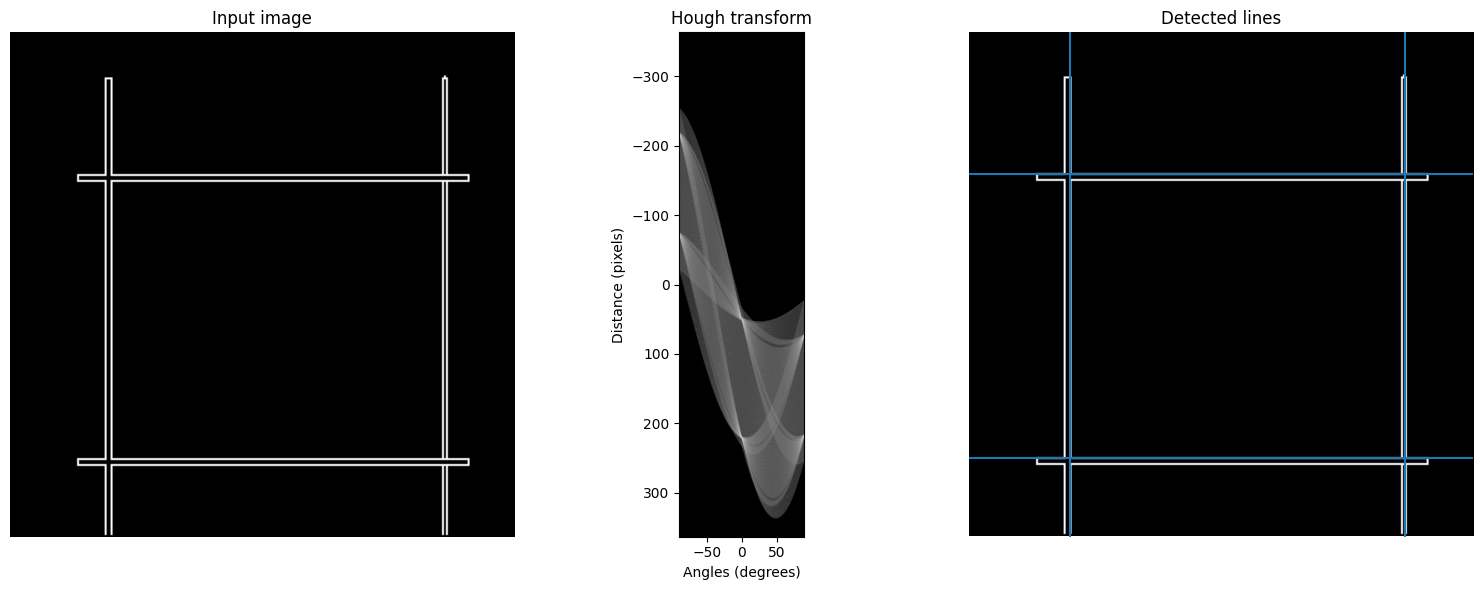

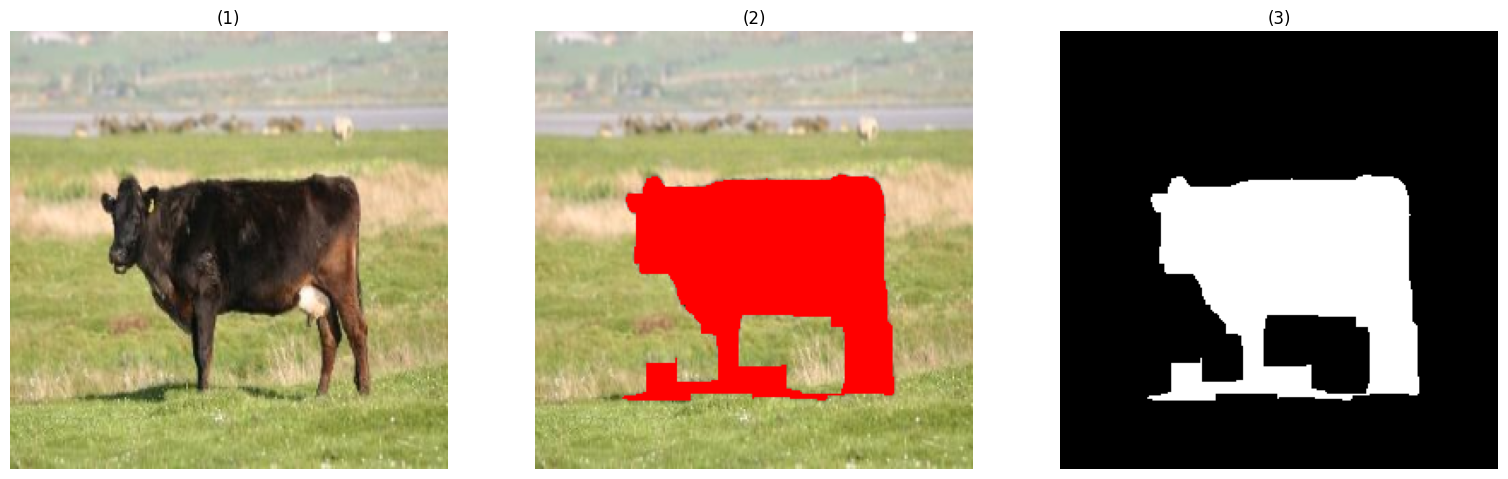

Ratio of white to black pixels: 0.21588134765625


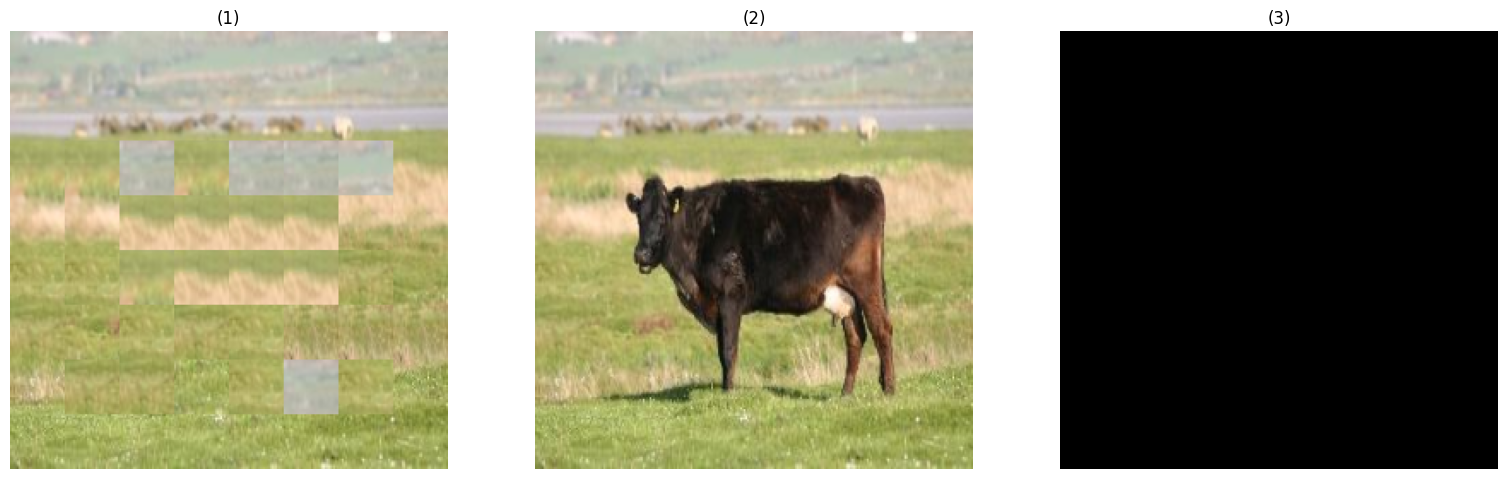

In [ ]:
cow_select=io.imread('images-to-be-tested/cow_with_selection.png')
cow_orig=io.imread('images-to-be-tested/cow.jpg')

target_img_size = (256, 256)

cow_sel_resize = cv2.resize(cow_select, target_img_size)
cow_sel_conversion = cow_sel_resize[:,:,:3]
cow_resized_orig = cv2.resize(cow_orig[:,:,:3], target_img_size)


# # Create an instance of the RegionDetection overlap=32
region_detector_1 = RegionDetection(cow_resized_orig, cow_sel_conversion)
region_mask, binary_mask_test=region_detector_1.get_mask_by_region_detection()

binary_mask_test=binary_mask_test[:,:,0]

grayLevelImg = cow_resized_orig#(rgb2gray(cow_resized_orig)*255).astype('uint8')
white_pixels = np.sum(binary_mask_test == 1)
black_pixels = np.sum(binary_mask_test == 0)

# Calculate the ratio
ratio = white_pixels / (white_pixels + black_pixels)
print(f"Ratio of white to black pixels: {ratio}")

newImg= main(grayLevelImg,binary_mask_test,32,32)
show_images([newImg,grayLevelImg,   binary_mask_test])




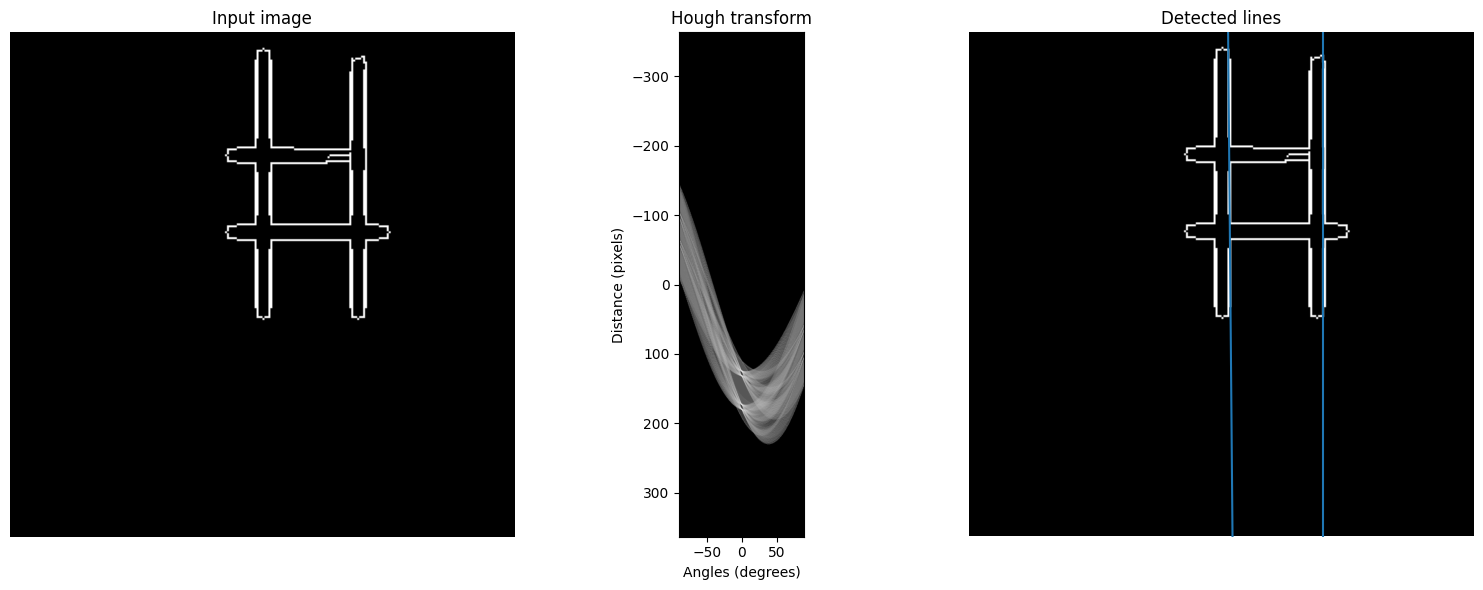

ValueError: not enough values to unpack (expected 4, got 0)

In [1232]:
cow_select=io.imread('images-to-be-tested/animalselect.png')
cow_orig=io.imread('images-to-be-tested/animal.jpg')

target_img_size = (256, 256)

cow_sel_resize = cv2.resize(cow_select, target_img_size)
cow_sel_conversion = cow_sel_resize[:,:,:3]
cow_resized_orig = cv2.resize(cow_orig[:,:,:3], target_img_size)


# # Create an instance of the RegionDetection overlap=32
region_detector_1 = RegionDetection(cow_resized_orig, cow_sel_conversion)
region_mask, binary_mask_test=region_detector_1.get_mask_by_region_detection()

binary_mask_test=binary_mask_test[:,:,0]

grayLevelImg = cow_resized_orig#(rgb2gray(cow_resized_orig)*255).astype('uint8')
white_pixels = np.sum(binary_mask_test == 1)
black_pixels = np.sum(binary_mask_test == 0)

# Calculate the ratio
ratio = white_pixels / (white_pixels + black_pixels)
print(f"Ratio of white to black pixels: {ratio}")

newImg= main(grayLevelImg,binary_mask_test,32,32)
show_images([newImg,grayLevelImg,   binary_mask_test])
